# Introduction

The goal of this project is to analyze data from NFL teams specifically looking at the offensive and defensive score, rush yards, passing yards, and turnovers.

Questions: <br>
- What teams did our team win against and did the team go to the playoffs?
- Are there any patterns or trends in a team’s performance over the season?
- Does the team's record correlate with the offensive yardage, defensive yardage, or turnovers?
- How does the team score, rush yards, pass yards, and total yards look over time.


### Collect & Clean Data

This data was collected From https://www.pro-football-reference.com website 

**Data in our columns:**<br>
**Week**: The week of the football season in which the game was played.<br>
**Day**: The day of the week on which the game was played.<br>
**Date**: The date on which the game was played.<br>
**OT**: Indicates whether the game went into overtime or not.<br>
**Rec**: The record of the team playing the game at the time of the game.<br>
**Opp**: The record of the opposing team at the time of the game.<br>
**Tm**: The total points scored by the team playing the game.<br>
**Opp**: The total points scored by the opposing team.<br>
**1stD**: The number of first downs achieved by the team playing the game.<br>
**TotYd**: The total yards gained by the team playing the game.<br>
**PassY**: The total passing yards gained by the team playing the game.<br>
**RushY**: The total rushing yards gained by the team playing the game.<br>
**TO**: The number of turnovers committed by the team playing the game.<br>
**Offense**: The performance of the team's offense in the game.<br>
**Defense**: The performance of the team's defense in the game.<br>
**Sp. Tms**: The performance of the team's special teams (e.g., kickoffs, punts, returns) in the game.<br>

In [1]:
# Dictonary of the description of every column in the dataset, for less scrolling. 
Description = {
    "Week": "The week of the football season in which the game was played.",
    "Day": "The day of the week on which the game was played.",
    "Date": "The date on which the game was played.",
    "OT": "Indicates whether the game went into overtime or not.",
    "Rec": "The record of the team playing the game at the time of the game.",
    "Opp": "The record of the opposing team at the time of the game.",
    "Tm": "The total points scored by the team playing the game.",
    "Opp": "The total points scored by the opposing team.",
    "1stD": "The number of first downs achieved by the team playing the game.",
    "TotYd": "The total yards gained by the team playing the game.",
    "PassY": "The total passing yards gained by the team playing the game.",
    "RushY": "The total rushing yards gained by the team playing the game.",
    "TO": "The number of turnovers committed by the team playing the game.",
    "Offense": "The performance of the team's offense in the game.",
    "Defense": "The performance of the team's defense in the game.",
    "Sp. Tms": "The performance of the team's special teams (e.g., kickoffs, punts, returns) in the game.",
    "Defense_1stD": "The number of first downs allowed by the defense."
}



In [2]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


C:\Users\luisl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\luisl\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:



# Defining a function to get a dictonary of all NFL teams.
class Nfl_stats:
    # Created an init method that sets keys as nfl teams and values as the symbols to those teams
    
    def __init__(self):
        self.teams_symbols_dict = {}
        # Setting url we want to get the data from using requests and beautifulsoup to find nfl teams 
        url = "https://www.pro-football-reference.com/teams/"
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'html.parser')
        teams = soup.find("table", id="teams_active")

        # Finding the team names in html
        all_team_names = teams.find_all("th", {"class":"left",'data-stat': 'team_name'})

        # Team_names and urls for the teams list
        team_names = []
        team_urls = []
        
        # Parse throught the data in all_team_names and append names of teams to team_names and urls for those teams into team_urls
        for i in all_team_names[1:]:
            team_links = i.find("a")
            team_names.append(team_links.text.lower())
            team_urls.append(team_links.get("href").split("/")[2])
            
        # Updating teams_symbols_dict to show teams and symbols for those teams
        self.teams_symbols_dict.update(dict(zip(team_names, team_urls)))
        
            
        
    # Creating a dataframe that shows a team's stats for the season
    
    def team_stats(self, team, year):
        
        # Using the teams and symbols dictonary to find the each team's data
        teams_dict = self.teams_symbols_dict
        url = "https://www.pro-football-reference.com/teams/"

        # Making it easier to find the team's name in the teams_symbols_dict even if its uppercase or just the teams name not the city.
        full_team_name = ""
        for correct_team in teams_dict:
            if team in correct_team:
                full_team_name = correct_team
        
        # Finding the team's stats 
        team_symbol = teams_dict[full_team_name.lower()]
        url = f"{url}{team_symbol}/{year}.htm"
        html = requests.get(url).text
        soup = BeautifulSoup(html, "html.parser")
        table = soup.find("table", id="games")

        table_rows = table.find_all("tr")[2:]
        data = []
        for tr in table_rows:
            data.append([table_data.get_text(strip=True) for table_data in tr.find_all("td")])

        # Creating a dataframe with the team's stats
        df = pd.DataFrame(data)
        
        # Only getting the data from the columns that are relevent to the teams stats
        index = [0,1,4,6,8,9,10] + list(range(11,21))
        new_data = df.iloc[:,index].copy()

        # Finding column names
        columns_html = table.find_all("th", {"scope":"col"})
        columns = []

        for col in columns_html[1:]:
            columns.append(col.text)
        # Changing some column names and some that are duplicate so then we dont change both in dataframe later on
        columns[4] = "Result"
        columns[17] = "Toyd"
        columns[10] = "opp"
        columns[-4] = "Opp_TO"
        columns[-5] = "Opp_RushY"
        columns[-6] = "Opp_PassY"
        columns[-8] = "Opp_1stD"
        new_data.columns = [columns[num] for num in index]
        # Renaming columns in our dataframe so the stats match up
        team_stats_df = new_data.rename({
            "Rec": "Record", 
            "Opp": "Opposing_team",
            "Tm":"Team_score",
            "TotYd": "Offense_TotYd",
            "Toyd": "Opp_TotYd",
            "opp": "Opponent_score",
            "TO":"Offense_TO",
            "RushY": "Offense_RushY",
            "PassY": "Offense_PassY",
            "1stD": "Offense_1stD"


        }, axis="columns")

        # Replacing some columns into numbers so then we can do better analysis
        result_encoder = {'Result': {'L': 0, 'T': 0,'W': 1,' ' : pd.NA}}
        team_stats_df.replace(result_encoder, inplace=True)
        
        # Creating a week column so we know what week it is in the season
        week = list(range(1,len(team_stats_df) + 1))
        team_stats_df.insert(0, "Week", week)

        # Creating a column for team name and making it a title.
        team_name_col = pd.Series([f"{team.title()}"]).repeat(len(team_stats_df)).reset_index(drop=True)

        team_stats_df.insert(0,"Team_name", team_name_col)
        
        # Replacing strings with integers. 
        columns_int_list = ["Result","Team_score","Opponent_score","Offense_1stD","Offense_TotYd","Offense_PassY","Offense_RushY","Offense_TO","Opp_1stD","Opp_TotYd","Opp_PassY","Opp_RushY","Opp_TO"]
        for column in columns_int_list:
            columns_list_na = team_stats_df[column].replace(["","bye"],0)
            team_stats_df[column]= columns_list_na.astype(int)
        
        return team_stats_df


### Explore Data

Let's use our object and input the data we want to get; we are using panthers data from 2022.

In [4]:
# Calling the class
# To create an object we call Nfl_stats().team_stats("team name", Year)
team_data = Nfl_stats().team_stats("panthers", 2022)
team_data

,Team_name,Week,Day,Date,Result,Record,Opposing_team,Team_score,Opponent_score,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Opp_1stD,Opp_TotYd,Opp_PassY,Opp_RushY,Opp_TO
0,Panthers,1,Sun,September 11,0,0-1,Cleveland Browns,24,26,15,261,207,54,1,23,355,138,217,0
1,Panthers,2,Sun,September 18,0,0-2,New York Giants,16,19,18,275,129,146,2,18,265,162,103,0
2,Panthers,3,Sun,September 25,1,1-2,New Orleans Saints,22,14,12,293,148,145,0,19,426,342,84,3
3,Panthers,4,Sun,October 2,0,1-3,Arizona Cardinals,16,26,11,220,180,40,3,20,338,206,132,1
4,Panthers,5,Sun,October 9,0,1-4,San Francisco 49ers,15,37,15,308,244,64,1,22,397,244,153,1
5,Panthers,6,Sun,October 16,0,1-5,Los Angeles Rams,10,24,8,203,110,93,1,22,360,249,111,1
6,Panthers,7,Sun,October 23,1,2-5,Tampa Bay Buccaneers,21,3,14,343,170,173,0,17,322,276,46,0
7,Panthers,8,Sun,October 30,0,2-6,Atlanta Falcons,34,37,23,478,309,169,1,21,406,239,167,2
8,Panthers,9,Sun,November 6,0,2-7,Cincinnati Bengals,21,42,13,228,164,64,3,30,464,223,241,0
9,Panthers,10,Thu,November 10,1,3-7,Atlanta Falcons,25,15,18,333,101,232,0,20,291,153,138,1


In [5]:
# Shape of dataset
rows = team_data.shape[0]
columns = team_data.shape[1]

print(f"There are {rows} rows and {columns} coulumns within this dataset.")


There are 18 rows and 19 coulumns within this dataset.


In [6]:

# Teams played 

num_teams_played = team_data[team_data["Opposing_team"] != "Bye Week"].groupby("Opposing_team").size().count()

print("Number of teams played against: " + str(num_teams_played))


teams_played = team_data.groupby("Opposing_team").size()
teams_played = teams_played[teams_played.index != "Bye Week"]
print("\n"
      "Breakdown of teams they played: \n",
      teams_played)

print("\nTeams played more than once: \n" +f"{str(teams_played[teams_played == 2])}")



Number of teams played against: 14

Breakdown of teams they played: 
 Opposing_team
Arizona Cardinals       1
Atlanta Falcons         2
Baltimore Ravens        1
Cincinnati Bengals      1
Cleveland Browns        1
Denver Broncos          1
Detroit Lions           1
Los Angeles Rams        1
New Orleans Saints      2
New York Giants         1
Pittsburgh Steelers     1
San Francisco 49ers     1
Seattle Seahawks        1
Tampa Bay Buccaneers    2
dtype: int64

Teams played more than once: 
Opposing_team
Atlanta Falcons         2
New Orleans Saints      2
Tampa Bay Buccaneers    2
dtype: int64


In [7]:
# Missing values
missing_values = team_data.isna().sum()

print("The number of missing values for this dataset in each column: \n\n" + str(missing_values))

The number of missing values for this dataset in each column: 

Team_name         0
Week              0
Day               0
Date              0
Result            0
Record            0
Opposing_team     0
Team_score        0
Opponent_score    0
Offense_1stD      0
Offense_TotYd     0
Offense_PassY     0
Offense_RushY     0
Offense_TO        0
Opp_1stD          0
Opp_TotYd         0
Opp_PassY         0
Opp_RushY         0
Opp_TO            0
dtype: int64


In [8]:
# Unique number of days played

unique_days = team_data.Day.unique()[team_data.Day.unique() != ""]
print(f"Unique days played: {unique_days}")

num_unique_days_played = team_data[team_data.Day != ""].groupby("Day")["Day"].count()

print(f"\nCount of days team played: \n{num_unique_days_played}")


Unique days played: ['Sun' 'Thu' 'Sat']

Count of days team played: 
Day
Sat     1
Sun    15
Thu     1
Name: Day, dtype: int64


### Analyze Data

Looking at the teams panthers won aginanst. 

In [9]:
# Teams that panthers lost against and teams that they won against

won_against = team_data[team_data.Result == 1].Opposing_team
print(f"\nWon against: \n{won_against.to_string(index=False)}")

lost_against = team_data[team_data.Result == 0].Opposing_team
print(f"\nLost against: \n{lost_against.to_string(index=False)}")


Won against: 
  New Orleans Saints
Tampa Bay Buccaneers
     Atlanta Falcons
      Denver Broncos
    Seattle Seahawks
       Detroit Lions
  New Orleans Saints

Lost against: 
    Cleveland Browns
     New York Giants
   Arizona Cardinals
 San Francisco 49ers
    Los Angeles Rams
     Atlanta Falcons
  Cincinnati Bengals
    Baltimore Ravens
            Bye Week
 Pittsburgh Steelers
Tampa Bay Buccaneers


In [10]:
# Team score mean
team_score_win = team_data[team_data.Result == 1].Team_score.mean()
team_score_loss = team_data[team_data.Result == 0].Team_score.mean()

# Opponent score mean
opp_score_win = team_data[team_data.Result == 0].Opponent_score.mean()
opp_score_loss = team_data[team_data.Result == 1].Opponent_score.mean()

print(f"The panthers average score when they win a game is {team_score_win}. \nThe average score when panthers lose is {round(team_score_loss,2)}.")

print(f"\nThe opponent average score when they win is {round(opp_score_win,2)} \nThe opponent average score when they lose is {round(opp_score_loss,2)}")

The panthers average score when they win a game is 24.0. 
The average score when panthers lose is 16.27.

The opponent average score when they win is 25.27 
The opponent average score when they lose is 13.71


In [11]:

# Team average scores and opponent average scores

avg_score = round(team_data["Team_score"].mean(),2)


avg_opp_score = round(team_data["Opponent_score"].mean(),2)
team = team_data["Team_name"].unique()
print(f"{team[0]} score {avg_score} on average.The opponents average score is {avg_opp_score}. The opponents on average score more than the panthers.")

# Playoffs

playoffs = team_data["Date"] == "Playoffs"

if playoffs.any():
    print(f"{team} made it to the playoffs!")
else:
    print(f"{team[0]} did not make it to the playoffs.")

team_result = team_data.Result
print(f"\nGames won: {str(team_result.sum())}")
print(f"Games lost: {str(team_result.count()-team_result.sum())}")

Panthers score 19.28 on average.The opponents average score is 20.78. The opponents on average score more than the panthers.
Panthers did not make it to the playoffs.

Games won: 7
Games lost: 11


Here we created an object that can show us offense and opponent bar graphs and the weather they won or lost a game.
The first parameter asks for the data, the second parameter can be offense or opponent’s data, the third parameter is an option to show the charts, last parameter is to save all the charts to a png.


In [12]:
# Changing index to show from 1 to the length of the data inseted of starting from 0 
team_data.index = range(1,len(team_data)+1)

# Excluding rows that have blank data so the data is less affected 
team_data = team_data[(team_data["Opposing_team"] != "Bye Week") & (team_data["Date"] != "Playoffs")]


# Creating a function to show a bar graph for the offensive and defensive side of the team 
# The function will take 4 parameters the data, opponent or offense side we want to visualize, to show chart or not, and to save to png
def full_bargraphs(data, side="defense",show_chart=True,save=False):
    
    # Filtering the data to only get the side we want
    stats = data.filter(regex=side).copy()
    
    # Adding column for result to so we can include it in our bar graph
    if side =="Offense":
        stats["Team_score"] = data.Team_score.values
    else: 
        stats["Opponent_score"] = data.Opponent_score
        
    
    stats["Result"] = data.Result.values
    # Changing the name from Opp to Opponent 
    stats.columns = stats.columns.str.replace("Opp_", "Opponent_")
    
    # Empty list for each chart
    charts = []
    # Using a for loop to create all bar graphs at once
    for col in stats.iloc[:,:-1]:
        
        # Using sns and plt to create figure, barplot, legend,add text under the graph, and add titles
        fig = plt.figure(figsize=(8,7))
        plot = sns.barplot(x=stats.index, y=col, data=stats, hue="Result",dodge=False, palette={1: "green", 0: "orange"});
        legend_elements = [plt.Rectangle((0,0), 1, 1, color='orange', label='Loss'),plt.Rectangle((0,0), 1, 1, color='green', label='Win')]
        legend = plt.legend(handles= legend_elements,title="Result",labels=["Loss", "Win"], loc="upper left")
        
        
        # Spliting column name to create the title and make it more readable
        title = col.split("_")
        chart_title = plt.title(title[0]+ " " + title[1] +" Bar Chart")
        
        # Getting the mean for each column during a loss or a win
        mean_win = round(stats[stats["Result"]== 1][col].mean(),2)
        mean_loss = round(stats[stats["Result"]== 0][col].mean(),2)
        
        # Adding text to the bottom of the graph to show the mean for each 
        plt.figtext(.5,.052,f"\nThe {title[0].lower()}'s average number of {title[1]}'s when panthers win is: {str(mean_win)}",ha="center", fontsize=13)
        plt.figtext(.5,.00067,f"The {title[0].lower()}'s average number of {title[1]}'s when panthers lose: {str(mean_loss)}",ha="center", fontsize=13)
        
        # Adding the bar graphs to the empty chart list
        charts.append(plot)
        
        # using if statment to save the barchart if its True
        if save:
            plt.savefig(f"charts/{team_data.Team_name.unique()[0]} {title[0]} {title[1]}.png")
            
        # Showing the chart if show_chart is True and closing the chart if show_chart it False
        if show_chart:
            plt.show()
            plt.close()
        else:
            plt.close()
    return charts

The bar graphs below show the offense's veriables with a different hue depending on whether the result is a win or a loss for each game, we can look at patterns that stand out like rush yards, 1st downs, and turnovers.
- If we look at 1st downs, we can see that when the offense had more first downs the opponent lost.
- When we look at rush yards there are a lot of yellow bars, which shows the opponent wins when they have more rush yards.
- Looking at the opponent's turnovers we can see that that the opponent had more turnovers when they lost.


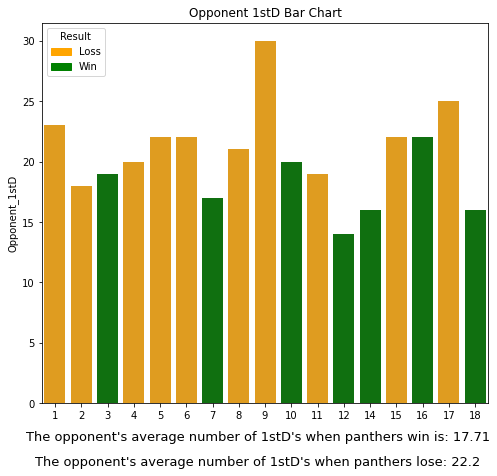

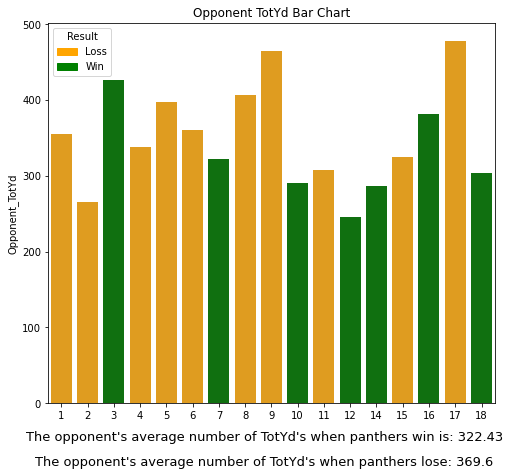

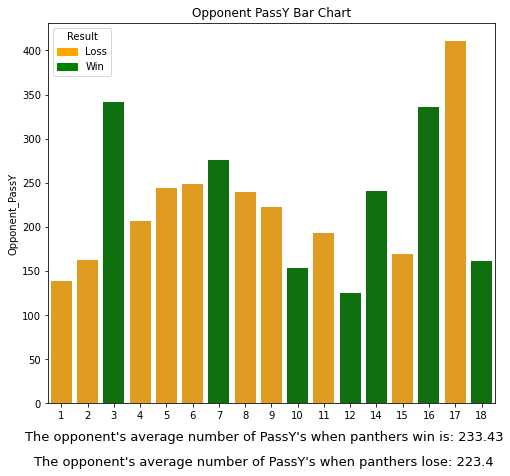

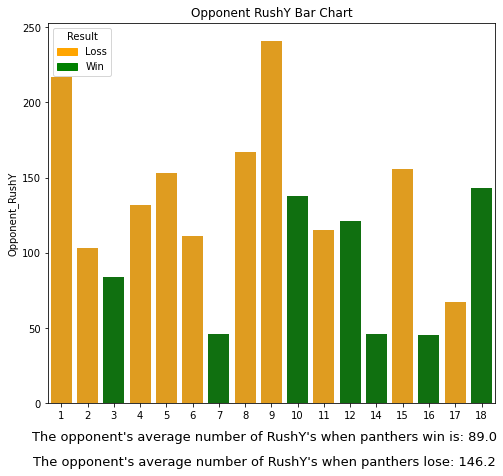

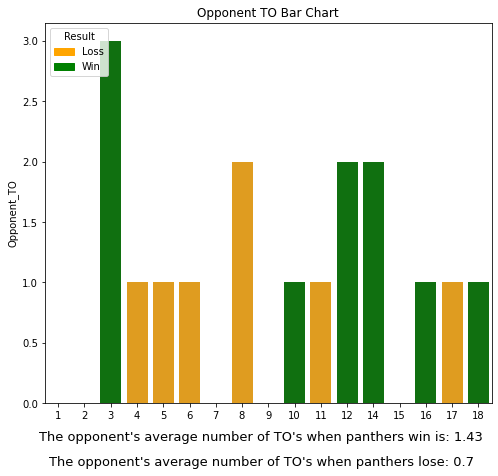

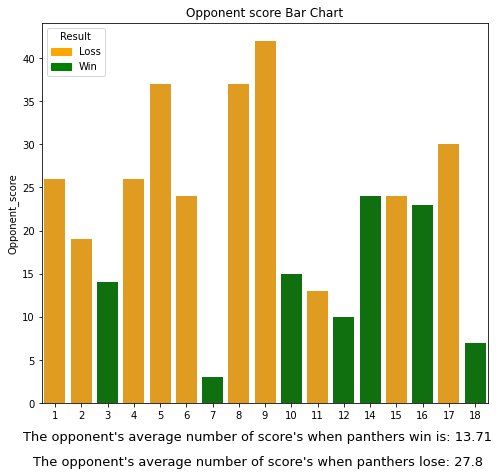

In [13]:
full_bargraphs(team_data,side="Opp_");

The bar graphs below show the offensive veriables from our dataset, the hue is a different depending on whether the result is a win or a loss for each game. Green hue for win and yellow for loss. We will look at some patterns that stand out.
- If we look at the offense rush yards, we can see that the offense has more wins when they have more rush yards. 
- When we look at offense turnovers, we can see that it’s mostly yellow which means the result is usually a loss when the offense has turnovers.
  

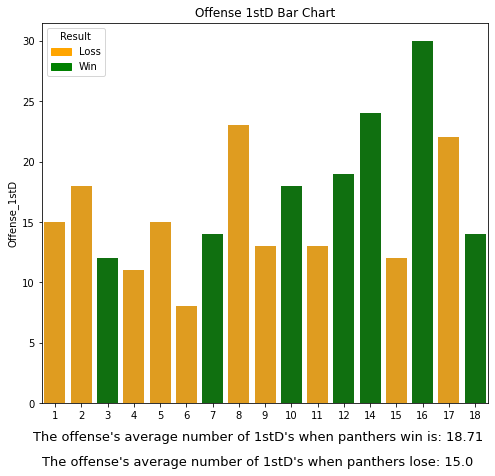

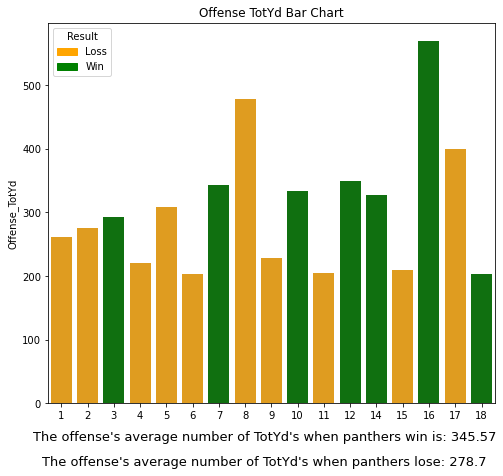

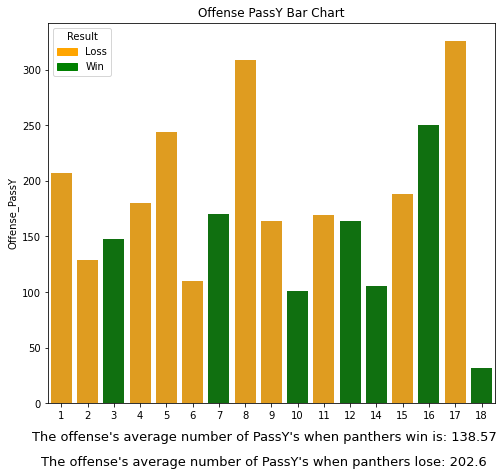

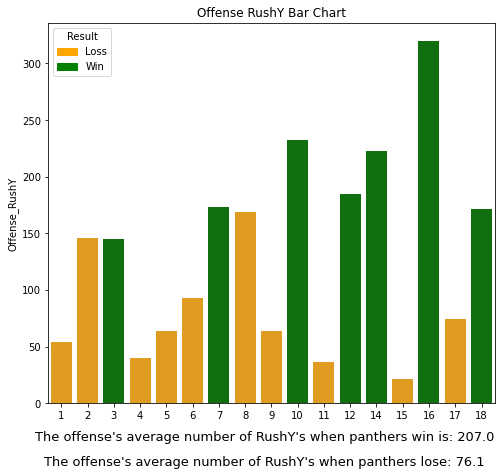

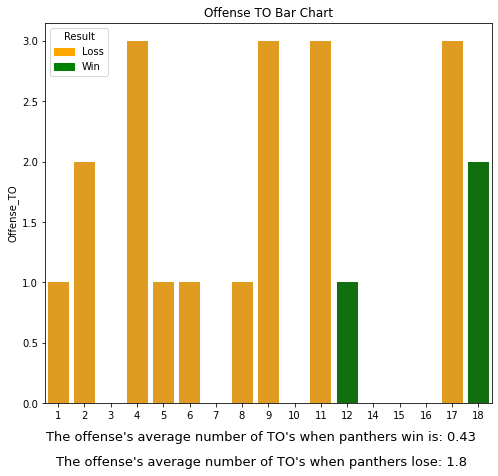

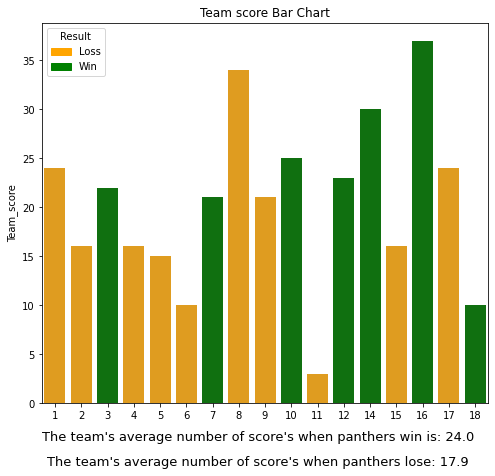

In [14]:
full_bargraphs(team_data, side="Offense");

In [15]:
# Calculating the correlation between team data variables and a certain variable


# Result variable correlation with team data 

result_corrwith = team_data.corrwith(team_data["Result"])

# Score variable correlation with team data 
score_corrwith = team_data.corrwith(team_data["Team_score"])


# Getting postive correlation for result and score
result_corr_positive = result_corrwith[team_data.corrwith(team_data["Result"]) >= .50]
score_corr_positive = score_corrwith[team_data.corrwith(team_data["Team_score"]) >= .50]

# Negative correlation for result
result_corr_negative = result_corrwith[team_data.corrwith(team_data["Result"]) <= -.50]

# Opponent positive correlation with score
opp_score_positive = team_data.corrwith(team_data.Opponent_score)[(team_data.corrwith(team_data.Opponent_score) >= .50)]

# There was no negative correlation on score of less than -.50 from offense

# Opponent negative correlation with score
opp_score_negative = team_data.corrwith(team_data.Opponent_score)[(team_data.corrwith(team_data.Opponent_score) <= -.50)]


print(f"\nPositive Result Correlation Coefficient:  \n{result_corr_positive}\n\nNegative Result Correlation Coefficient: \n{result_corr_negative}")

print(f"\nPositive Score Correlation Coefficient: \n{score_corr_positive} \n\nOpponent Correlation  \n{opp_score_positive}")

print(f"\nNegative Opponent Score Correlation: \n{opp_score_negative} ")


Positive Result Correlation Coefficient:  
Result           1.000000
Offense_RushY    0.795404
dtype: float64

Negative Result Correlation Coefficient: 
Opponent_score   -0.657117
Offense_TO       -0.579534
Opp_1stD         -0.597754
Opp_RushY        -0.515995
dtype: float64

Positive Score Correlation Coefficient: 
Team_score       1.000000
Offense_1stD     0.793107
Offense_TotYd    0.843615
Offense_RushY    0.642299
dtype: float64 

Opponent Correlation  
Opponent_score    1.000000
Offense_PassY     0.558539
Opp_1stD          0.771483
Opp_TotYd         0.649204
dtype: float64

Negative Opponent Score Correlation: 
Result   -0.657117
dtype: float64 


    Let's look at the correlation coefficients, A positive correlation coefficient indicates that the two variables move in the same direction, while a negative correlation coefficient indicates that they move in opposite directions.
    
    A strong positive correlation of 0.84 was found between the team's score and the total yards they gained. 
    This means that team with more total yards are more likely to score points. The same is true for offense 1st downs and offense rush yards.
    
    There is also a negative correlation between the result and opponent score, offense turn overs, and opponent 1st downs. 
    This means that the higher the opponent scores the more likely Panthers will lose, the more the turnovers the offense 
    has the more likely Panthers will lose, and the more 1st downs the opponent team has the more likely Panthers will lose. 
    
    There is also a strong positive correlation between score and offense 1st downs, offense total yards, and offense rush  
    yards. If Panthers earn more 1st down's, total yards, and rush yards they are more likely to score points against opponents.


Now that we’ve looked at some patterns, we can look at the correlation.
<br>Here we look at which veriables were correlated more than .50 or have a positive correlation, or less than .50 negative correlation.


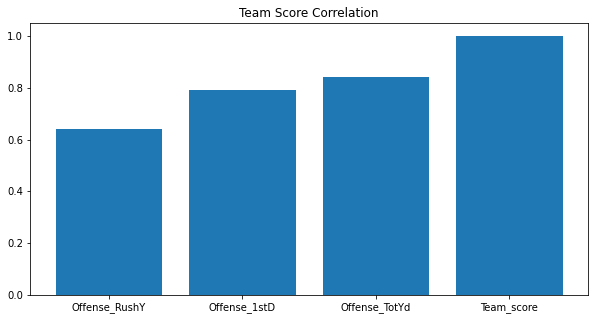

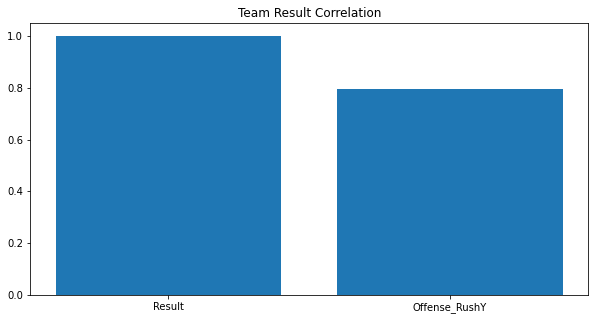

Oppenent score had a negative correlation with Result.


In [16]:
# Correlation histogram

# Score correlation 
score_corr_positive = score_corr_positive.sort_values()
score_pos_x = score_corr_positive.index
score_pos_y = score_corr_positive.values


fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(score_pos_x, score_pos_y)
plt.title("Team Score Correlation")
plt.show()
plt.close()

# Result correlation
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(result_corr_positive.index, result_corr_positive.values)
plt.title("Team Result Correlation")
plt.show()
plt.close()

print("Oppenent score had a negative correlation with Result.")

Variables that had the highest correlation:
- Team score and Offense total yards
- Result of the game and Offense rush yards
- Opponent score and opponent 1st downs 
- Result of the game and opponent 1st downs
   

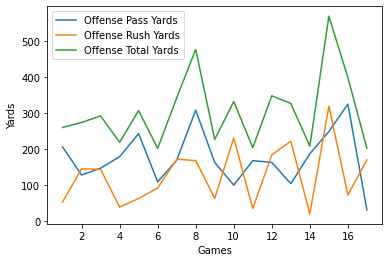

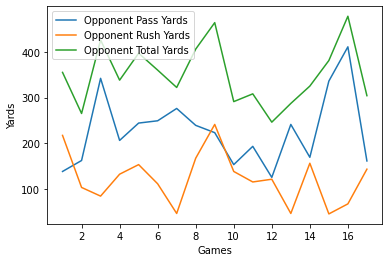

In [17]:
# Making a line plot with offense/defense rush, pass and, total yards


# Plotting offense pass yards, rush yards, and total yards
plt.plot(range(1,len(team_data["Offense_PassY"]) + 1),team_data["Offense_PassY"], label="Offense Pass Yards")
plt.plot(range(1,len(team_data["Offense_RushY"]) + 1 ), team_data["Offense_RushY"], label="Offense Rush Yards")
plt.plot(range(1, len(team_data["Offense_TotYd"]) +  1), team_data["Offense_TotYd"], label="Offense Total Yards")
plt.xlabel("Games")
plt.ylabel("Yards")

plt.legend()

plt.show()
plt.close()


# Plotting Opponent pass yards, rush yards, and total yards
plt.plot(range(1,len(team_data["Opp_PassY"]) + 1),team_data["Opp_PassY"], label="Opponent Pass Yards")
plt.plot(range(1,len(team_data["Opp_RushY"]) + 1 ), team_data["Opp_RushY"], label="Opponent Rush Yards")
plt.plot(range(1, len(team_data["Opp_TotYd"]) +  1), team_data["Opp_TotYd"], label="Opponent Total Yards")
plt.xlabel("Games")
plt.ylabel("Yards")

plt.legend()

plt.show()
plt.close()

We can see that the both opponents and the team offense total yards, pass yards, and rush yards move together.


### Conclusions


#### The goal of this project is to analyze data from NFL teams specifically looking at the offensive and defensive score, rush yards, passing yards, and turnovers.

•	**What teams did panthers win against and did they go to the playoffs?**
<br>

Panthers won 7 games and lost 11
- **Won against** 
    <br> - New Orleans Saints &nbsp;&nbsp;&nbsp; - Tampa Bay Buccaneers
    <br> - Atlanta Falcons &nbsp;&nbsp;&nbsp; - Denver Broncos
    <br> - Seattle Seahawks &nbsp;&nbsp;&nbsp; - Detroit Lions
    <br> - New Orleans Saints
- **Lost against**
    <br> - Cleveland Browns &nbsp;&nbsp;&nbsp; - New York Giants
    <br> - Arizona Cardinals &nbsp;&nbsp;&nbsp; - San Francisco 49ers
    <br> - Los Angeles Rams &nbsp;&nbsp;&nbsp; - Atlanta Falcons
    <br> - Cincinnati Bengals &nbsp;&nbsp;&nbsp; - Baltimore Ravens
    <br> - Pittsburgh Steelers &nbsp;&nbsp;&nbsp; - Tampa Bay Buccaneers


•	**Are there any patterns or trends in a team’s performance over the season?**

We find patterns in the multiple bar graphs where the offensive turnovers are higher when panthers lost, and offense rush yards were higher when panthers won. On the other side the opponent had slightly more 1st downs when they won.

<br>

•	**Does the team’s records correlate with the offensive yardage, defensive yardage, or turnovers?**

There is positive correlation between team score, offense 1st downs, offense total yards, and offense rush yards this means that offense has a higher chance of scoring points when any of those variables are high. There is both a Strong relationship between  opponent 1st downs and opponent wins, the more first downs the opponent has the more likely they will score and win. 

•	**How does the team score rush yards, pass yards, and total yards look over time.**

The total yards, rush yards, and pass yards all move together, meaning when there are more rush yards and pass yards there is also more total yards for both offense and the opponent.


### Linear regression

    Offense_RushY
1              54
2             146
3             145
4              40
5              64
6              93
7             173
8             169
9              64
10            232
11             36
12            185
14            223
15             21
16            320
17             74
18            171


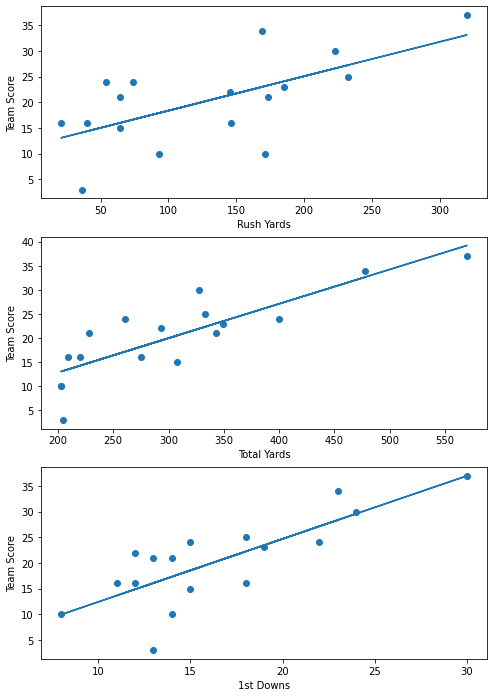

In [18]:

# Linear regression with team score, rush yards,total yards, and 1st downs. 


team_score = team_data.Team_score


team_rush = team_data[["Offense_RushY"]]
total_yards = team_data[["Offense_TotYd"]]
first_downs = team_data[["Offense_1stD"]]
print(team_rush)


# Creating figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Linear regression model
model = LinearRegression()

# Fitting model and predicting
model.fit(team_rush.values, team_score)
predict = model.predict(team_rush.values)



# Creating plots with linear regression line
axs[0].scatter(team_rush.values, team_score)
axs[0].plot(team_rush.values, predict)
axs[0].set_xlabel("Rush Yards")
axs[0].set_ylabel("Team Score")


# Fitting model and predicting
model.fit(total_yards, team_score)
predict = model.predict(total_yards)


# # Creating plots with linear regression line
axs[1].scatter(total_yards.values, team_score)
axs[1].plot(total_yards.values, predict)
axs[1].set_xlabel("Total Yards")
axs[1].set_ylabel("Team Score")

# # Fitting model and predicting
model.fit(first_downs.values, team_score)
predict = model.predict(first_downs)


# # Creating plots with linear regression line
axs[2].scatter(first_downs.values, team_score)
axs[2].plot(first_downs.values, predict)
axs[2].set_xlabel("1st Downs")
axs[2].set_ylabel("Team Score")


plt.show()


**Another way we can look at the relationship between some of these veriables is linear regression.**
<br>
We look at score and its relationship with rush yards, total yards, and 1st downs to see how much these variables are related.
<br>

**Examining Rush yards (independent veriable) and team score (dependent variable):**
- The scatter plot shows the rush yards on the x axis and team score on the y axis. 
- The regression line shows a positive relationship between rush yards and team score, but there is some variability since the points are scattered. Factors that might affect the liner regression graph are not enough data or that there are other ways a team can score.
- Overall there is variability because the points are not all close to the liner regression line but there is a positive correlation. 

**Examining Total yards (independent veriable) and team score (dependent variable):**
- The scatter plot shows the total yards on the x axis and team score on the y axis.
- The line shows a positive relationship between total yards and team score, the points are closer to the line. When the total yards go up the team score goes up, there is a positive relationship with total yards and team score more than rush yards.

**Examining 1st Downs (independent veriable) and team score (dependent variable):**
- The scatter plot shows the total yards on the x axis and team score on the y axis.
- The points on the scatter plot are closer to the regression line, there is an overall trend of the relationship between 1st downs and team score. 



